<a href="https://colab.research.google.com/github/AubreyYueng/LC-yiyun/blob/master/CSE521_project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/My Drive/CSE521"

21DMProject.pdf       contrast_cls_tree_pd.pdf	full_cls_tree_ped
bakarydata.xls	      full_cls_tree_pd		full_cls_tree_ped.pdf
contrast_cls_tree_pd  full_cls_tree_pd.pdf


In [ ]:
!pip install feature_engine

In [ ]:
from sklearn import tree
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import graphviz
from sklearn.tree import export_graphviz
from sklearn.neural_network import MLPClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
from feature_engine.discretisation import EqualFrequencyDiscretiser
from feature_engine.discretisation import EqualWidthDiscretiser
from sklearn.preprocessing import KBinsDiscretizer

In [ ]:
%matplotlib inline

# S1. Data Preparation

## Create Project Data

Read data from excel, with uesless rows and columns dropped:

In [ ]:
p_data = pd.read_excel('/content/drive/My Drive/CSE521/bakarydata.xls')

# drop useless rows
p_data.drop(0, inplace=True)
p_data.drop(p_data.tail(5).index, inplace = True)
p_data.drop(p_data.columns[[0, 1]], axis = 1, inplace=True)

Identify missing value:

In [ ]:
na_count = p_data.isna().sum()
na_count = na_count[na_count>0]
na_count.sort_values(ascending=False)

Mo      87
Co      83
As      71
Cd      69
Pb      54
Sc      49
Ni      39
Li      38
V       11
Cu      10
Cr       3
Zn       3
S        3
TiO2     2
P2O5     1
dtype: int64

Fill missing value with zero:





In [ ]:
p_data = p_data.fillna(0)

Fix non-numeric value of **Li** as zero:

In [ ]:
p_data['Li'] = (
    pd.to_numeric(p_data['Li'],
                  errors='coerce')
      .fillna(0)
    )

Modify class value according to the folloing mappings:

C1 : R. Carbonatees AND R. Carbonatees impures

C2 : Pyrate

C3 : Charcopyrite

C4 : Galene

C5 : Spahlerite

C6 : Sediments terrigenes 

In [ ]:
p_data.loc[(p_data['Type de roche.1'] == 'R. carbonatées'),'Type de roche.1']='C1'
p_data.loc[(p_data['Type de roche.1'] == 'R. carbonatées impures'),'Type de roche.1']='C1'
p_data.loc[(p_data['Type de roche.1'] == 'Pyrite'),'Type de roche.1']='C2'
p_data.loc[(p_data['Type de roche.1'] == 'Chalcopyrites'),'Type de roche.1']='C3'
p_data.loc[(p_data['Type de roche.1'] == 'Galène'),'Type de roche.1']='C4'
p_data.loc[(p_data['Type de roche.1'] == 'Spahlerite'),'Type de roche.1']='C5'
p_data.loc[(p_data['Type de roche.1'] == 'Sédiments terrigènes'),'Type de roche.1']='C6'

In [ ]:
p_data.head()

,CaO+MgO,Al2O3,TiO2,Fe2O3*,MnO,MgO,CaO,Na2O,K2O,P2O5,S,Zn,Pb,Cu,As,Cd,Cr,Ni,Sc,V,Co,Ba,Sr,Li,Mo,Rb,Y,Zr,Nb,Cs,La,Ce,Pr,Nd,Sm,Eu,Gd,Tb,Dy,Ho,Er,Tm,Yb,Lu,Hf,Ta,Th,U,Type de roche.1
1,58.549206,0.042894,0.001139,0.050882,0.009550,24.522963,34.026243,0.034961,0.018328,0.049970,71.530422,2.096808,0.000000,0.438867,0.000000,0.0,2.698218,0.000000,0.000000,0.845225,0.0,5.569708,42.763512,1.174213,0.0,0.440076,2.163039,0.597249,0.083757,0.040505,1.172904,0.964773,0.235636,0.863947,0.160446,0.039142,0.197101,0.025383,0.199311,0.048939,0.145865,0.016902,0.075020,0.009734,0.014938,0.005829,0.037011,1.565582,C1
2,55.919433,0.055319,0.000731,0.077360,0.023425,23.536592,32.382841,0.022787,0.024499,0.006280,88.690182,5.528533,0.000000,1.376918,0.000000,0.0,5.653707,2.148826,0.297706,18.087690,0.0,15.856666,61.729719,0.000000,0.0,0.496700,3.406543,1.220929,0.204263,0.037611,1.179032,1.232091,0.239014,0.947284,0.182285,0.052349,0.252717,0.040555,0.332474,0.088865,0.283060,0.037272,0.198003,0.027808,0.019643,0.019673,0.067928,2.375750,C1
3,54.328172,0.156345,0.009747,0.311645,0.047901,22.643130,31.685042,0.028780,0.018019,0.212453,257.516069,7.309161,8.154236,1.544720,6.851397,0.0,3.654581,0.000000,0.227564,4.031342,0.0,15.083999,69.945659,1.524375,0.0,0.532014,6.513842,2.764447,0.294448,0.064564,3.028671,2.530951,0.677124,2.756731,0.522547,0.126732,0.578496,0.082647,0.603493,0.145837,0.451323,0.052108,0.240718,0.033128,0.057313,0.013743,0.206904,4.566766,C1
4,53.279291,0.040651,0.000529,0.047324,0.011572,22.160244,31.119048,0.029067,0.009013,0.052931,138.817188,6.454112,0.000000,4.247102,0.000000,0.0,2.930315,0.000000,0.000000,0.686213,0.0,3.830923,48.824985,0.000000,0.0,0.096883,2.294541,1.098521,0.189039,0.024016,1.176993,1.015006,0.261456,1.014408,0.198480,0.050619,0.240267,0.032758,0.244824,0.059446,0.172986,0.019559,0.089642,0.012349,0.018667,0.019894,0.029204,1.334084,C1
5,52.288110,0.078805,0.001139,0.150688,0.015111,16.450731,35.837379,0.025634,0.058705,10.414421,753.746789,5.287055,3.677137,2.146037,0.000000,0.0,5.033433,4.370112,0.000000,6.106451,0.0,13.868278,120.860913,4.647926,0.0,2.508807,24.534712,1.699024,0.195438,0.138065,12.376389,10.234285,1.866422,8.563298,1.323299,0.405690,2.071026,0.288239,2.273738,0.593413,1.798298,0.210936,1.012964,0.136158,0.027061,0.006339,0.037171,13.485565,C1


In [ ]:
# p_data.tail()

## Create Project Expert Data

Use only the most important
attributes **S, Zn, Pb, Cu, CaO+MgO, CaO, MgO, Fe2O3** as determined by the expert.

In [ ]:
e_data = p_data[['S', 'Zn', 'Pb', 'Cu', 'CaO+MgO', 'CaO', 'MgO', 'Fe2O3*', 'Type de roche.1']]
e_data.head()

,S,Zn,Pb,Cu,CaO+MgO,CaO,MgO,Fe2O3*,Type de roche.1
1,71.530422,2.096808,0.000000,0.438867,58.549206,34.026243,24.522963,0.050882,C1
2,88.690182,5.528533,0.000000,1.376918,55.919433,32.382841,23.536592,0.077360,C1
3,257.516069,7.309161,8.154236,1.544720,54.328172,31.685042,22.643130,0.311645,C1
4,138.817188,6.454112,0.000000,4.247102,53.279291,31.119048,22.160244,0.047324,C1
5,753.746789,5.287055,3.677137,2.146037,52.288110,35.837379,16.450731,0.150688,C1


# S2: Data preprocessing

## For the Decision Trees 

**Descriptive Classifier** you use your chosen method of the **discretization**
of Project DATA - **PD** creating a set **PD1** of data with no more than 4 values (bins) for each
attribute. Different attributes do not need to have the same number of values (bins) and you do not
need to use the same discretization methods for all of them. Describe which discretization method
(must use at least two) you used for each attributes.
Create the EXPERT DATA - **PED1** from the **PD1** by using only the most important
attributes **S, Zn, Pb, Cu, CaO+MgO, CaO, MgO, Fe2O3**.

Use **Equal-Frequency Discretization** for the following features: 

> 'CaO+MgO', "Al2O3", "TiO2", "Fe2O3*", "MnO", "Na2O", "K2O", "P2O5", "S", "Zn", "Cu", "Cr", "Ni", "Sc", "V", "Ba", "Sr", "Li", "Rb", "Y", "Zr", "Nb", "Cs", "La", "Ce", "Pr", "Nd", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu", "Hf", "Ta", "Th", "U"

In [ ]:
eq_freq_disc = EqualFrequencyDiscretiser(q=4, variables=['CaO+MgO', "Al2O3", "TiO2", "Fe2O3*", "MnO", "Na2O", "K2O", "P2O5", "S", "Zn", "Cu", "Cr", "Ni", "Sc", "V", "Ba", "Sr", "Li", "Rb", "Y", "Zr", "Nb", "Cs", "La", "Ce", "Pr", "Nd", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu", "Hf", "Ta", "Th", "U"])
pd1 = eq_freq_disc.fit_transform(p_data)


Use **Equal-Width Discretization** for the following features:

> 'MgO', 'CaO', 'Mo', 'Co', 'Cd', 'Pb', 'As'

In [ ]:
eq_width_disc = EqualWidthDiscretiser(bins=4, variables = ['MgO', 'CaO', 'Mo', 'Co', 'Cd', 'Pb', 'As'])
tmp = eq_width_disc.fit_transform(p_data)
for col in ['MgO', 'CaO', 'Mo', 'Co', 'Cd', 'Pb', 'As']:
  pd1[col] = tmp[col]

### Result of **PD1**(first 5 lines):

In [ ]:
pd1.head()

,CaO+MgO,Al2O3,TiO2,Fe2O3*,MnO,MgO,CaO,Na2O,K2O,P2O5,S,Zn,Pb,Cu,As,Cd,Cr,Ni,Sc,V,Co,Ba,Sr,Li,Mo,Rb,Y,Zr,Nb,Cs,La,Ce,Pr,Nd,Sm,Eu,Gd,Tb,Dy,Ho,Er,Tm,Yb,Lu,Hf,Ta,Th,U,Type de roche.1
1,3,1,1,0,0,3,3,3,1,2,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,C1
2,3,1,0,0,2,3,3,1,1,0,0,2,0,0,0,0,2,1,1,3,0,2,2,0,0,1,2,1,1,1,1,1,0,1,1,1,1,1,2,2,2,2,2,2,1,1,2,3,C1
3,3,2,2,2,3,3,3,2,1,3,1,2,0,1,0,0,1,0,1,2,0,2,2,1,0,2,3,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,3,C1
4,3,1,0,0,0,3,3,2,0,2,0,2,0,3,0,0,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,C1
5,3,2,1,1,1,2,3,2,2,3,2,1,0,2,0,0,2,1,0,2,0,2,3,2,0,2,3,2,1,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,2,1,1,3,C1


### Result of **PED1**(first 5 lines):

In [ ]:
ped1 = pd1[['S', 'Zn', 'Pb', 'Cu', 'CaO+MgO', 'CaO', 'MgO', 'Fe2O3*', 'Type de roche.1']]

In [ ]:
ped1.head()

,S,Zn,Pb,Cu,CaO+MgO,CaO,MgO,Fe2O3*,Type de roche.1
1,0,0,0,0,3,3,3,0,C1
2,0,2,0,0,3,3,3,0,C1
3,1,2,0,1,3,3,3,2,C1
4,0,2,0,3,3,3,3,0,C1
5,2,1,0,2,3,3,2,1,C1


## For the Neural Network 

**Non - Descriptive Classifiers** use your chosen method of normalization
of the Project DATA - **PD** and Project EXPERT DATA - **PED**. Specify which.

In [ ]:
scaler = MinMaxScaler()
pd2 = pd1.copy()
pd2.iloc[:,0:-1] = scaler.fit_transform(p_data.iloc[:,0:-1].to_numpy())

### Normalized data **PD**(first 5 lines):

In [ ]:
pd2.head()

,CaO+MgO,Al2O3,TiO2,Fe2O3*,MnO,MgO,CaO,Na2O,K2O,P2O5,S,Zn,Pb,Cu,As,Cd,Cr,Ni,Sc,V,Co,Ba,Sr,Li,Mo,Rb,Y,Zr,Nb,Cs,La,Ce,Pr,Nd,Sm,Eu,Gd,Tb,Dy,Ho,Er,Tm,Yb,Lu,Hf,Ta,Th,U,Type de roche.1
1,1.000000,0.002364,0.001320,0.000517,0.013700,1.000000,0.896355,0.007947,0.001706,0.002545,0.000220,0.000066,0.000000,0.000063,0.000000,0.0,0.023367,0.000000,0.000000,0.002204,0.0,0.000759,0.057849,0.014122,0.0,0.003722,0.027714,0.002432,0.002428,0.008251,0.012805,0.006739,0.009896,0.014328,0.011644,0.006085,0.018214,0.010435,0.010089,0.010599,0.009838,0.008296,0.005770,0.005492,0.002246,0.004550,0.002721,0.001531,C1
2,0.954713,0.003282,0.000847,0.001158,0.036402,0.959076,0.853004,0.004706,0.002346,0.000320,0.000273,0.000173,0.000000,0.000197,0.000000,0.0,0.048961,0.009506,0.013581,0.047156,0.0,0.003134,0.091869,0.000000,0.0,0.004229,0.057615,0.006246,0.012924,0.007459,0.012980,0.010544,0.010309,0.017091,0.015567,0.010954,0.027414,0.023493,0.023909,0.028977,0.029895,0.029973,0.027538,0.029782,0.003219,0.024586,0.005362,0.002446,C1
3,0.927311,0.010747,0.011300,0.006829,0.076450,0.922007,0.834597,0.006302,0.001674,0.010820,0.000793,0.000229,0.000077,0.000221,0.037053,0.0,0.031649,0.000000,0.010382,0.010510,0.0,0.002956,0.106606,0.018334,0.0,0.004545,0.132332,0.015686,0.020779,0.014834,0.065979,0.029034,0.063872,0.077075,0.076691,0.038373,0.081302,0.059718,0.052036,0.055203,0.054493,0.045761,0.035099,0.036931,0.011010,0.016003,0.017230,0.004920,C1
4,0.909248,0.002198,0.000613,0.000431,0.017007,0.901973,0.819667,0.006378,0.000740,0.002696,0.000428,0.000202,0.000000,0.000606,0.000000,0.0,0.025376,0.000000,0.000000,0.001789,0.0,0.000358,0.068721,0.000000,0.0,0.000646,0.030876,0.005498,0.011598,0.003738,0.012922,0.007454,0.013053,0.019316,0.018476,0.010316,0.025355,0.016782,0.014812,0.015435,0.013803,0.011124,0.008358,0.009006,0.003017,0.024907,0.002055,0.001270,C1
5,0.892179,0.005017,0.001320,0.002933,0.022798,0.665091,0.944131,0.005464,0.005891,0.530384,0.002322,0.000165,0.000035,0.000306,0.000000,0.0,0.043589,0.019332,0.000000,0.015920,0.0,0.002675,0.197935,0.055900,0.0,0.022261,0.565658,0.009170,0.012155,0.034948,0.333826,0.138692,0.209272,0.269565,0.220536,0.141203,0.328187,0.236655,0.225381,0.261232,0.251405,0.214776,0.171786,0.175397,0.004753,0.005287,0.002735,0.014990,C1


### Normalize data **PED**(first 5 lines):

In [ ]:
ped2 = pd2[['S', 'Zn', 'Pb', 'Cu', 'CaO+MgO', 'CaO', 'MgO', 'Fe2O3*', 'Type de roche.1']]
ped2.head()

,S,Zn,Pb,Cu,CaO+MgO,CaO,MgO,Fe2O3*,Type de roche.1
1,0.000220,0.000066,0.000000,0.000063,1.000000,0.896355,1.000000,0.000517,C1
2,0.000273,0.000173,0.000000,0.000197,0.954713,0.853004,0.959076,0.001158,C1
3,0.000793,0.000229,0.000077,0.000221,0.927311,0.834597,0.922007,0.006829,C1
4,0.000428,0.000202,0.000000,0.000606,0.909248,0.819667,0.901973,0.000431,C1
5,0.002322,0.000165,0.000035,0.000306,0.892179,0.944131,0.665091,0.002933,C1


# S3: Building Classifiers

For the Decision Tree, **Descriptive Classifiers** use the sets of data **PD**, **PED** for **Experiments 1, 2** and **PD1**, **PED1** for **Experiment 3**.

For the Neural Network, Non- Descriptive Classifiers use the normalized sets of data **PD**, **PED**. Use at least **TWO different Network TOPOLOGIES**; one can be the Tool default one, and the other
designed by you. Compare results.

Declare feature vector and target variable:

In [ ]:
X_pd = p_data.drop(['Type de roche.1'], axis=1)
y_pd = p_data['Type de roche.1']

In [ ]:
X_ped = e_data.drop(['Type de roche.1'], axis=1)
y_ped = e_data['Type de roche.1']

Split data into separate training and test set:

In [ ]:
X_train_pd, X_test_pd, y_train_pd, y_test_pd = train_test_split(X_pd, y_pd, test_size = 0.33, random_state = 42)

In [ ]:
X_train_ped, X_test_ped, y_train_ped, y_test_ped = train_test_split(X_ped, y_ped, test_size = 0.33, random_state = 42)

### Experiment 1: full classification

Use the **PD** and **PED** data to perform the **full classification**, i.e. to build
Decision Tree classifier, and Neural Network Classifier for all classes **C1- C6** simultaneously.

#### Decision Tree classifier

In [ ]:
def decision_cls(x_train, y_train, x_test, y_test, classes):
  # Create Decision Tree classifer object
  clf = DecisionTreeClassifier()

  # Train Decision Tree Classifer
  clf = clf.fit(x_train, y_train)

  #Predict the response for test dataset
  y_pred = clf.predict(x_test)

  # Model Accuracy, how often is the classifier correct?
  print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
  return clf 

##### For **PD**:

Accuracy: 0.9090909090909091


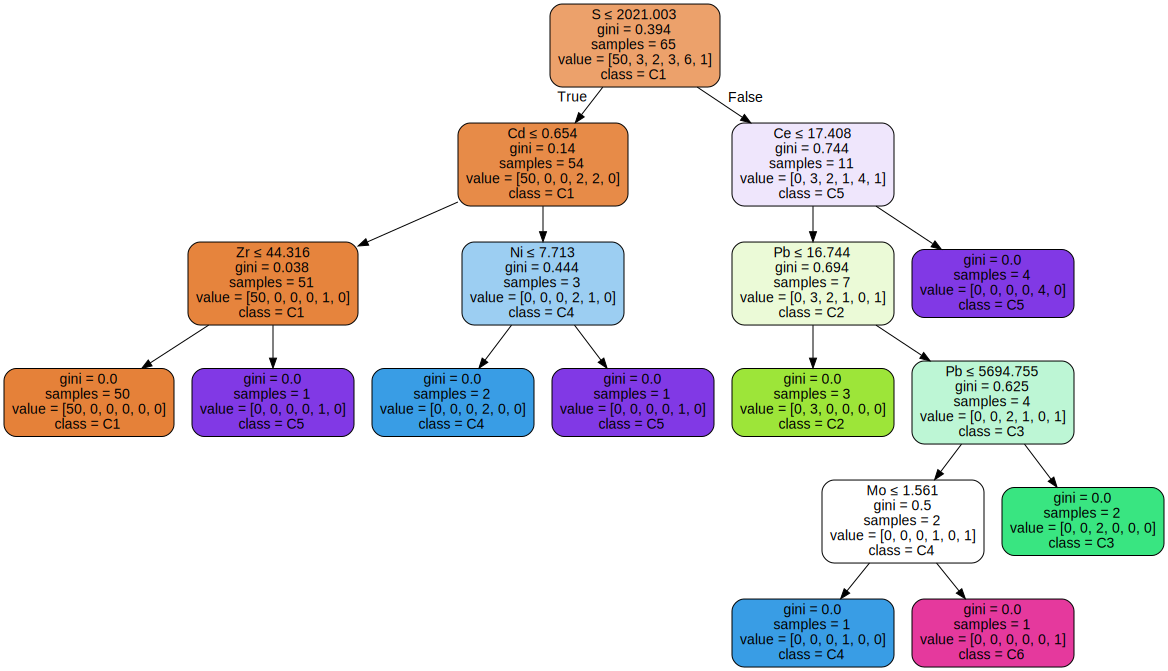

In [ ]:
classes = ['C1','C2','C3','C4','C5','C6']
clf = decision_cls(X_train_pd, y_train_pd, X_test_pd, y_test_pd, classes)
gv = graphviz.Source(export_graphviz(clf, out_file=None, 
                           feature_names = X_train_pd.columns,
                           class_names = classes,
                         filled=True, rounded=True,  
                         special_characters=True)  ) 
gv.render(filename = "/content/drive/My Drive/CSE521/full_cls_tree_pd")
gv


##### For **PED**:

Accuracy: 0.8181818181818182


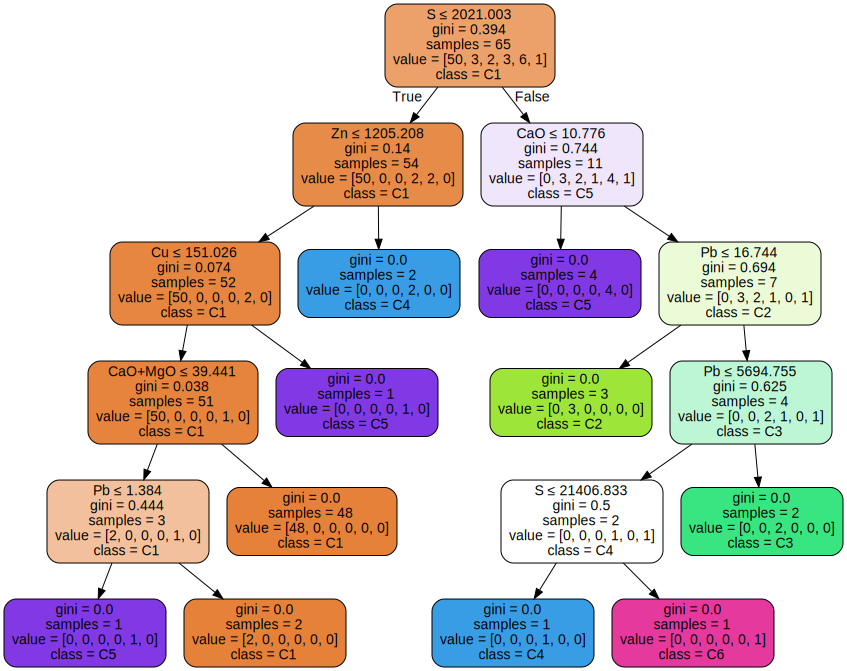

In [ ]:
clf = decision_cls(X_train_ped, y_train_ped, X_test_ped, y_test_ped, classes)
gv = graphviz.Source(export_graphviz(clf, out_file=None, 
                           feature_names = X_train_ped.columns,
                           class_names = classes,
                         filled=True, rounded=True,  
                         special_characters=True)  ) 
gv.render(filename = "/content/drive/My Drive/CSE521/full_cls_tree_ped")
gv

#### Neural Network classification

In [ ]:
X_np = pd2.drop(['Type de roche.1'], axis=1)
y_np = pd2['Type de roche.1']
X_npe = ped2.drop(['Type de roche.1'], axis=1)
y_npe = ped2['Type de roche.1']

X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(X_np, y_np, test_size = 0.3, random_state = 21)
X_train_npe, X_test_npe, y_train_npe, y_test_npe = train_test_split(X_npe, y_npe, test_size = 0.3, random_state = 21)

##### Topology 1

> hidden_layer_sizes: default 100 layers

> activation: default 'relu'

In [ ]:
def neural(mlp, X_train, y_train, X_test, y_test, msg1, msg2):
  mlp.fit(X_train,y_train)
  predict_train = mlp.predict(X_train)
  predict_test = mlp.predict(X_test)
  print(msg1)
  print(confusion_matrix(y_test,predict_test))
  print(classification_report(y_test,predict_test))
  print(msg2)
  print(confusion_matrix(y_train,predict_train))
  print(classification_report(y_train,predict_train))

###### For normalized PD:

In [ ]:
neural(MLPClassifier(), X_train_np,y_train_np, X_test_np, y_test_np, "Test accuracy for PD using topology 1:", "Training accuracy for PD using topology 1:")

Test accuracy for PD using topology 1:
[[25  0  0  0]
 [ 1  0  0  0]
 [ 1  0  1  0]
 [ 0  0  0  2]]
              precision    recall  f1-score   support

          C1       0.93      1.00      0.96        25
          C2       0.00      0.00      0.00         1
          C4       1.00      0.50      0.67         2
          C6       1.00      1.00      1.00         2

    accuracy                           0.93        30
   macro avg       0.73      0.62      0.66        30
weighted avg       0.90      0.93      0.91        30

Training accuracy for PD using topology 1:
[[52  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0]
 [ 0  0  0  1  0  0  0]
 [ 2  0  0  0  1  0  0]
 [ 0  0  0  0  0  7  0]
 [ 0  0  0  0  0  0  1]]
              precision    recall  f1-score   support

          C1       0.93      1.00      0.96        52
          C2       0.00      0.00      0.00         2
          C3       1.00      1.00      1.00         2
          C4       1.00      1.00   

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###### For normalized PED

In [ ]:
neural(MLPClassifier(), X_train_npe,y_train_npe, X_test_npe, y_test_npe, "Test accuracy for PED using topology 1:", "Training accuracy for PED using topology 1:")

Test accuracy for PED using topology 1:
[[25  0  0  0]
 [ 1  0  0  0]
 [ 1  0  0  1]
 [ 0  0  0  2]]
              precision    recall  f1-score   support

          C1       0.93      1.00      0.96        25
          C2       0.00      0.00      0.00         1
          C4       0.00      0.00      0.00         2
          C6       0.67      1.00      0.80         2

    accuracy                           0.90        30
   macro avg       0.40      0.50      0.44        30
weighted avg       0.82      0.90      0.85        30

Training accuracy for PED using topology 1:
[[52  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0]
 [ 0  0  0  1  0  0  0]
 [ 3  0  0  0  0  0  0]
 [ 2  0  0  0  0  5  0]
 [ 1  0  0  0  0  0  0]]
              precision    recall  f1-score   support

          C1       0.87      1.00      0.93        52
          C2       0.00      0.00      0.00         2
          C3       1.00      1.00      1.00         2
          C4       1.00      1.00 

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### Topology 2

> 'hidden_layer_sizes' argument set to three layers. 

> select 'relu' as the activation function

> select 'adam' as the solver for weight optimization

###### For normalized PD:

In [ ]:
neural(MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500), X_train_np,y_train_np, X_test_np, y_test_np, "Test accuracy for PD using topology 2:", "Training accuracy for PD using topology 2:")

Test accuracy for PD using topology 2:
[[25  0  0  0  0]
 [ 1  0  0  0  0]
 [ 1  0  0  0  1]
 [ 0  0  0  2  0]
 [ 0  0  0  0  0]]
              precision    recall  f1-score   support

          C1       0.93      1.00      0.96        25
          C2       0.00      0.00      0.00         1
          C4       0.00      0.00      0.00         2
          C6       1.00      1.00      1.00         2
     Pyyrite       0.00      0.00      0.00         0

    accuracy                           0.90        30
   macro avg       0.39      0.40      0.39        30
weighted avg       0.84      0.90      0.87        30

Training accuracy for PD using topology 2:
[[52  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0]
 [ 0  0  0  1  0  0  0]
 [ 2  0  0  0  1  0  0]
 [ 0  0  0  0  0  7  0]
 [ 0  0  0  0  0  0  1]]
              precision    recall  f1-score   support

          C1       0.93      1.00      0.96        52
          C2       0.00      0.00      0.00         2
      

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###### For normalized PED

In [ ]:
neural(MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500), X_train_npe,y_train_npe, X_test_npe, y_test_npe, "Test accuracy for PED using topology 2:", "Training accuracy for PED using topology 2:")

Test accuracy for PED using topology 2:
[[25  0  0  0  0]
 [ 1  0  0  0  0]
 [ 0  0  0  0  0]
 [ 1  0  1  0  0]
 [ 0  0  1  0  1]]
              precision    recall  f1-score   support

          C1       0.93      1.00      0.96        25
          C2       0.00      0.00      0.00         1
          C3       0.00      0.00      0.00         0
          C4       0.00      0.00      0.00         2
          C6       1.00      0.50      0.67         2

    accuracy                           0.87        30
   macro avg       0.39      0.30      0.33        30
weighted avg       0.84      0.87      0.85        30

Training accuracy for PED using topology 2:
[[52  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0]
 [ 0  0  0  1  0  0  0]
 [ 2  0  0  0  1  0  0]
 [ 1  0  0  0  0  6  0]
 [ 0  0  0  0  0  1  0]]
              precision    recall  f1-score   support

          C1       0.91      1.00      0.95        52
          C2       0.00      0.00      0.00         2
    

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Experiment 2: contrast classification

Use the **PD** and **PED** data to perform the **contrast classification** for the class **C1**
i.e. to build a Decision Tree classifier, and Neural Network Classifiers contrasting the class **C1** with
a class **notC1** that contains other classes.

#### Decision Tree classifier

In [ ]:
pd_ct = p_data.copy()
ped_ct = e_data.copy()

pd_ct.loc[(pd_ct['Type de roche.1'] != 'C1'),'Type de roche.1']='notC1'
ped_ct.loc[(ped_ct['Type de roche.1'] != 'C1'),'Type de roche.1']='notC1'

X_pd = pd_ct.drop(['Type de roche.1'], axis=1)
y_pd = pd_ct['Type de roche.1']
X_ped = ped_ct.drop(['Type de roche.1'], axis=1)
y_ped = ped_ct['Type de roche.1']

X_train_pd, X_test_pd, y_train_pd, y_test_pd = train_test_split(X_pd, y_pd, test_size = 0.33, random_state = 19)
X_train_ped, X_test_ped, y_train_ped, y_test_ped = train_test_split(X_ped, y_ped, test_size = 0.33, random_state = 5)

##### For PD

Accuracy: 0.9393939393939394


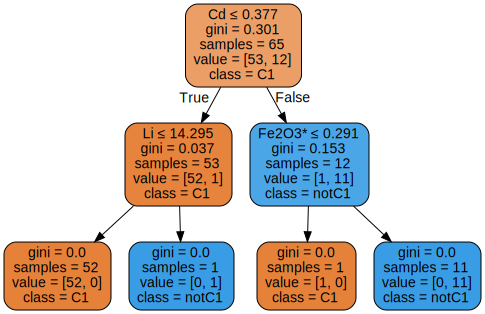

In [ ]:
classes = ['C1','notC1']
clf = decision_cls(X_train_pd, y_train_pd, X_test_pd, y_test_pd, classes)
gv = graphviz.Source(export_graphviz(clf, out_file=None, 
                           feature_names = X_train_pd.columns,
                           class_names = classes,
                         filled=True, rounded=True,  
                         special_characters=True)  ) 
gv.render(filename = "/content/drive/My Drive/CSE521/contrast_cls_tree_pd")
gv

##### For PED

Accuracy: 0.8787878787878788


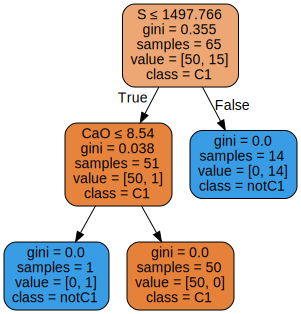

In [ ]:
clf = decision_cls(X_train_ped, y_train_ped, X_test_ped, y_test_ped, classes)
gv = graphviz.Source(export_graphviz(clf, out_file=None, 
                           feature_names = X_train_ped.columns,
                           class_names = classes,
                         filled=True, rounded=True,  
                         special_characters=True)  ) 
gv.render(filename = "/content/drive/My Drive/CSE521/contrast_cls_tree_ped")
gv

#### Neural Network

In [ ]:
pd_ct = pd2.copy()
ped_ct = ped2.copy()

pd_ct.loc[(pd_ct['Type de roche.1'] != 'C1'),'Type de roche.1']='notC1'
ped_ct.loc[(ped_ct['Type de roche.1'] != 'C1'),'Type de roche.1']='notC1'

X_np = pd_ct.drop(['Type de roche.1'], axis=1)
y_np = pd_ct['Type de roche.1']
X_npe = ped_ct.drop(['Type de roche.1'], axis=1)
y_npe = ped_ct['Type de roche.1']

X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(X_np, y_np, test_size = 0.3, random_state = 21)
X_train_npe, X_test_npe, y_train_npe, y_test_npe = train_test_split(X_npe, y_npe, test_size = 0.3, random_state = 21)

##### For PD

In [ ]:
neural(MLPClassifier(), X_train_np,y_train_np, X_test_np, y_test_np, "Test accuracy for PD using topology 1:", "Training accuracy for PD using topology 1:")

Test accuracy for PD using topology 1:
[[25  0]
 [ 2  3]]
              precision    recall  f1-score   support

          C1       0.93      1.00      0.96        25
       notC1       1.00      0.60      0.75         5

    accuracy                           0.93        30
   macro avg       0.96      0.80      0.86        30
weighted avg       0.94      0.93      0.93        30

Training accuracy for PD using topology 1:
[[52  0]
 [ 3 13]]
              precision    recall  f1-score   support

          C1       0.95      1.00      0.97        52
       notC1       1.00      0.81      0.90        16

    accuracy                           0.96        68
   macro avg       0.97      0.91      0.93        68
weighted avg       0.96      0.96      0.95        68



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


##### For PED

In [ ]:
neural(MLPClassifier(), X_train_npe,y_train_npe, X_test_npe, y_test_npe, "Test accuracy for PED using topology 1:", "Training accuracy for PED using topology 1:")

Test accuracy for PED using topology 1:
[[25  0]
 [ 2  3]]
              precision    recall  f1-score   support

          C1       0.93      1.00      0.96        25
       notC1       1.00      0.60      0.75         5

    accuracy                           0.93        30
   macro avg       0.96      0.80      0.86        30
weighted avg       0.94      0.93      0.93        30

Training accuracy for PED using topology 1:
[[52  0]
 [ 8  8]]
              precision    recall  f1-score   support

          C1       0.87      1.00      0.93        52
       notC1       1.00      0.50      0.67        16

    accuracy                           0.88        68
   macro avg       0.93      0.75      0.80        68
weighted avg       0.90      0.88      0.87        68



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


# Conclusion

1. (5pts)
For each TOOL and each set of DATA and each EXPERIMENT describe shortly the resulting Classifier
and the **parameters** (testing method, network topology, number of epochs to converge... type of
Decision Tree, **write set of discriminant rules**. etc..) used to build it.

2. (5pts)
Compare the resulting **Descriptive Classifiers** with each other **testing methods**, **Rules Accuracy**
and **Predictive Accuracy**

3. (5pts)
Compare the resulting **Non Descriptive Classifiers** with each other on **topology** used **testing** and **predictive accuracy**

4. (5pts)
Compare each **Descriptive Classifier** with the resulting **Non-Descriptive Classifier** on **Predictive Accuracy** only.

5. (5pts)
Describe shortly the TOOLS you use.
Describe their similarity and differences for the tasks you used them for.
Describe your experience with the TOOLS and your preferences for one or the other regarding different
tasks.